<a href="https://colab.research.google.com/github/weagan/Reinforcement-Learning/blob/main/frozen_lake_dql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Q-Learning/Deep Q-Network (DQN) Explained | Python Pytorch Deep Reinforcement Learning
https://youtu.be/EUrWGTCGzlA?si=5bkI9OEDk_g7aheW

In [ ]:
!git clone https://github.com/johnnycode8/gym_solutions

Cloning into 'gym_solutions'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 112 (delta 38), reused 29 (delta 29), pack-reused 70 (from 1)
Receiving objects: 100% (112/112), 77.07 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import imageio

In [ ]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

In [ ]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('frozen_lake_dql.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts an state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15.

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='rgb_array')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Initialize success and failure counters
        successes = 0
        failures = 0

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        frames = [] # Initialize an empty list named frames

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

                # Capture the current frame
                frames.append(env.render())

            # Check episode outcome
            if reward == 1:
                successes += 1
            elif terminated: # If terminated and reward is not 1, it's a failure (fell into a hole)
                failures += 1

        env.close()
        # Save the collected frames as a GIF file
        imageio.mimsave(f'frozen_lake_dql_{is_slippery}.gif', frames, fps=1)

        return successes, failures


    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states


--- Training and Testing for is_slippery=False ---
Policy (random, before training):
00,R,[0.07 -0.01 0.14 -0.07] 01,L,[0.18 -0.02 0.11 0.08] 02,U,[0.10 0.11 0.11 0.13] 03,R,[0.09 0.07 0.22 0.11] 
04,R,[0.04 0.00 0.12 0.05] 05,L,[0.17 0.15 0.14 -0.02] 06,L,[0.12 0.09 0.00 0.10] 07,R,[0.18 -0.04 0.18 0.03] 
08,L,[0.24 0.06 0.13 0.05] 09,R,[0.03 -0.05 0.09 0.06] 10,L,[0.21 -0.13 0.08 0.11] 11,R,[0.12 0.10 0.13 0.12] 
12,R,[0.02 -0.03 0.19 0.11] 13,R,[0.10 -0.05 0.18 0.08] 14,L,[0.14 0.12 0.12 0.01] 15,L,[0.29 -0.04 0.14 0.09] 
Policy (trained):
00,R,[0.53 0.57 0.58 0.54] 01,R,[0.54 0.01 0.64 0.59] 02,D,[0.60 0.75 0.58 0.64] 03,L,[0.65 0.03 0.57 0.57] 
04,D,[0.58 0.65 0.02 0.54] 05,R,[0.45 0.62 0.66 0.43] 06,D,[-0.00 0.83 -0.00 0.66] 07,R,[0.54 0.44 0.78 0.43] 
08,R,[0.65 0.03 0.74 0.58] 09,R,[0.49 0.77 0.82 0.12] 10,D,[0.72 0.89 -0.00 0.73] 11,D,[0.59 0.76 0.45 0.51] 
12,R,[0.41 0.33 0.61 0.38] 13,R,[0.14 0.80 0.90 0.55] 14,R,[0.79 0.90 0.99 0.81] 15,L,[0.70 0.50 0.62 0.56] 

Non-Slippe

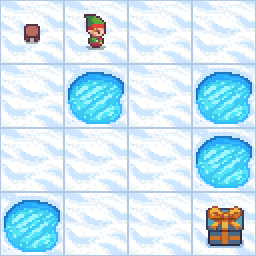

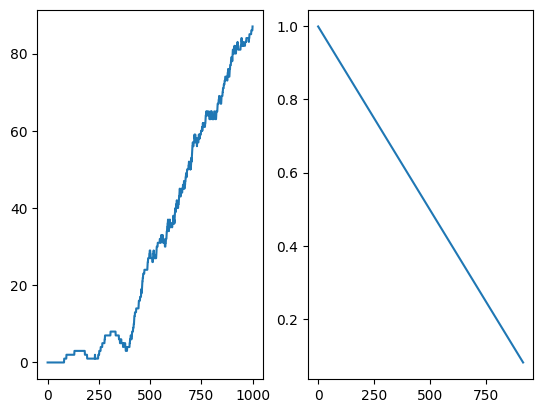

In [ ]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery_false = False
    print(f"\n--- Training and Testing for is_slippery={is_slippery_false} ---")
    frozen_lake.train(1000, is_slippery=is_slippery_false)
    successes_false, failures_false = frozen_lake.test(10, is_slippery=is_slippery_false)
    print(f"\nNon-Slippery Environment Results:")
    print(f"Successful episodes: {successes_false}")
    print(f"Failed episodes: {failures_false}")

    print(f"\nDisplaying GIF for is_slippery={is_slippery_false}:")
    from IPython.display import Image
    display(Image(open(f'frozen_lake_dql_{is_slippery_false}.gif','rb').read()))

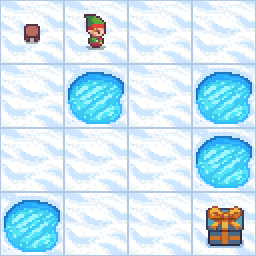

In [ ]:
from IPython.display import Image
#Image(open('frozen_lake_dql.gif','rb').read())
Image(open(f'frozen_lake_dql_{False}.gif','rb').read())


**Reasoning**:
Now, I will create an instance of the `FrozenLakeDQL` class, train it for the slippery environment (`is_slippery=True`), then test it to get the success and failure counts, and finally display the GIF and the recorded statistics.




--- Training and Testing for is_slippery=True ---
Policy (random, before training):
00,R,[0.03 -0.10 0.06 -0.08] 01,R,[0.02 -0.11 0.09 -0.11] 02,R,[0.10 -0.09 0.12 -0.05] 03,R,[0.01 -0.17 0.05 -0.09] 
04,R,[0.02 -0.18 0.04 -0.12] 05,L,[0.03 -0.14 0.01 -0.15] 06,L,[0.04 -0.14 0.02 -0.15] 07,L,[0.14 -0.09 0.05 -0.07] 
08,L,[0.13 -0.08 0.02 -0.09] 09,R,[0.01 -0.15 0.05 -0.11] 10,R,[0.02 -0.06 0.13 -0.06] 11,R,[0.08 -0.12 0.09 -0.07] 
12,R,[0.06 -0.14 0.09 -0.04] 13,L,[0.16 0.00 0.06 -0.06] 14,R,[0.05 -0.08 0.07 -0.09] 15,L,[0.10 -0.08 0.07 -0.08] 
Policy (trained):
00,D,[0.08 0.09 0.08 0.08] 01,U,[0.05 0.07 0.07 0.09] 02,D,[0.10 0.10 0.10 0.09] 03,U,[0.05 0.06 0.06 0.09] 
04,L,[0.10 0.10 0.09 0.08] 05,L,[0.13 0.11 0.10 0.03] 06,R,[0.11 0.09 0.15 0.06] 07,L,[0.25 0.20 0.17 0.10] 
08,U,[0.06 0.14 0.12 0.18] 09,D,[0.21 0.30 0.25 0.20] 10,L,[0.32 0.26 0.26 0.11] 11,R,[0.17 0.15 0.20 0.10] 
12,R,[0.14 0.13 0.19 0.16] 13,R,[0.22 0.31 0.44 0.31] 14,D,[0.43 0.70 0.58 0.46] 15,R,[0.16 0.17 0.17 0

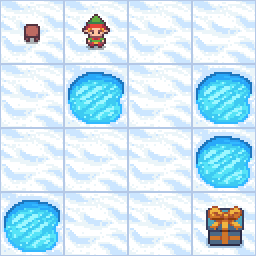

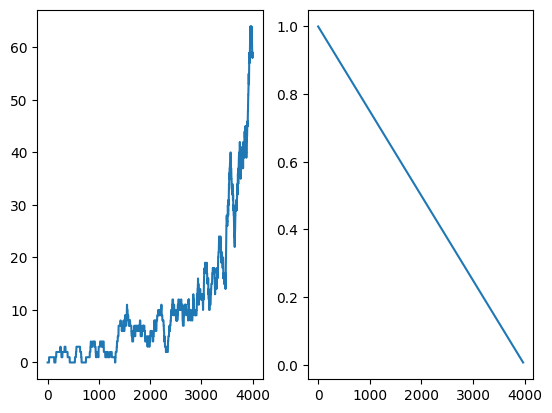

In [ ]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery_true = True
    print(f"\n--- Training and Testing for is_slippery={is_slippery_true} ---")
    frozen_lake.train(4000, is_slippery=is_slippery_true)
    successes_true, failures_true = frozen_lake.test(10, is_slippery=is_slippery_true)
    print(f"\nSlippery Environment Results:")
    print(f"Successful episodes: {successes_true}")
    print(f"Failed episodes: {failures_true}")

    print(f"\nDisplaying GIF for is_slippery={is_slippery_true}:")
    from IPython.display import Image
    display(Image(open(f'frozen_lake_dql_{is_slippery_true}.gif','rb').read()))

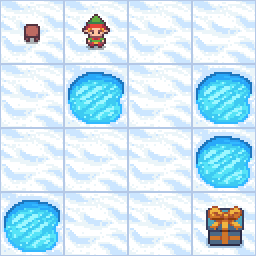

In [ ]:
from IPython.display import Image
Image(open(f'frozen_lake_dql_{True}.gif','rb').read())
